In [36]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import  MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, f1_score,jaccard_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import model_selection,metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import RepeatedKFold
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Normalization

%matplotlib inline

monster_df = pd.read_csv('../data/processed/Monster_modeling_df.csv')

monster_df.drop(columns={"Unnamed: 0", "Monster Name", "Size",'Type','Alignment'},axis=1, inplace=True)
monster_df.head()



,Traits,Reactions,Armor Class,Hit Points,Challenge,Proficiency Bonus,STR,DEX,CON,INT,WIS,CHA,Legendary Actions,Attack_Bonus,Spell_Bonus,Spell_Save_DC,WIS_SV,INT_SV,CHA_SV,STR_SV,DEX_SV,CON_SV,Arctic,Coastal,Desert,Forest,Grassland,Hill,Mountain,NA,Swamp,Underdark,Underwater,Urban,Average_Damage_per_Round,Damage Resistances,Damage Immunities,Condition Immunities,Damage Vulnerabilities,Spellcaster,Magic Resistance,Legendary Resistance,Regeneration,Undead Fortitude,Pack Tactics,Damage Transfer,Angelic Weapons,Charge,size_ordinal,aberration,beast,celestial,construct,dragon,elemental,fey,fiend,giant,humanoid,monstrosity,ooze,plant,swarm,undead,any alignment,any chaotic alignment,any evil alignment,any non-good alignment,any non-lawful alignment,chaotic evil,chaotic good,chaotic neutral,lawful evil,lawful good,lawful neutral,neutral,neutral evil,neutral good,unaligned,total_stats
0,1,0,19,207,15.0,5,23,12,21,18,15,17,1,11,0,0,7,4,8,6,6,10,0,0,0,1,0,0,0,0,0,0,0,0,97.000000,0,1,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,106
1,1,0,19,243,16.0,5,27,10,25,16,13,21,1,13,0,0,6,3,10,8,5,12,0,0,0,0,0,0,1,0,0,0,0,1,103.000000,0,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,112
2,1,0,18,200,13.0,5,22,10,22,8,12,12,1,11,0,0,6,-1,6,6,5,11,1,0,0,0,0,0,0,0,0,0,0,0,94.333333,0,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86
3,1,0,15,90,5.0,3,14,20,14,6,10,6,0,8,0,0,0,-2,-2,2,5,2,0,0,1,0,0,0,1,0,0,0,0,0,28.000000,3,1,8,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,70
4,0,0,12,19,0.5,2,16,14,14,6,12,7,0,5,0,0,1,-2,-2,3,2,2,0,0,0,1,0,0,0,0,0,0,0,0,12.000000,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,69


In [ ]:
#Input Variables: Size, Type, Environment, Alignment, CR(disguised as 4x player level)
#Output Variables: Stats, Saving Throws, Traits(barebones), Attack Bonus, Damage per Round, Reactions (y/n), Legendary Actions (y/n)

LinearRegression (and related)
KNeighborsRegressor
DecisionTreeRegressor
RandomForestRegressor (and related)

In [ ]:
monster_df.columns

Index(['Traits', 'Reactions', 'Armor Class', 'Hit Points', 'Challenge',
       'Proficiency Bonus', 'STR', 'DEX', 'CON', 'INT', 'WIS', 'CHA',
       'Legendary Actions', 'Attack_Bonus', 'Spell_Bonus', 'Spell_Save_DC',
       'WIS_SV', 'INT_SV', 'CHA_SV', 'STR_SV', 'DEX_SV', 'CON_SV', 'Arctic',
       'Coastal', 'Desert', 'Forest', 'Grassland', 'Hill', 'Mountain', 'NA',
       'Swamp', 'Underdark', 'Underwater', 'Urban', 'Average_Damage_per_Round',
       'Damage Resistances', 'Damage Immunities', 'Condition Immunities',
       'Damage Vulnerabilities', 'Spellcaster', 'Magic Resistance',
       'Legendary Resistance', 'Regeneration', 'Undead Fortitude',
       'Pack Tactics', 'Damage Transfer', 'Angelic Weapons', 'Charge',
       'size_ordinal', 'aberration', 'beast', 'celestial', 'construct',
       'dragon', 'elemental', 'fey', 'fiend', 'giant', 'humanoid',
       'monstrosity', 'ooze', 'plant', 'swarm', 'undead', 'any alignment',
       'any chaotic alignment', 'any evil alignment', 

## MultOutput Machine Learning
Classic machine learning fails here since it generally maps multiple inputs to a single output. We could run independent regressions, predict each variable one at a time. This ignores correlations in the outputs however, so it isn't optimal.

We will try two methods: Random Forests with multioutput regressor and using Tensorflow Keras API

In [9]:
## Train Test Split

X = monster_df[['Coastal','Arctic','Desert','Forest','Grassland', 'Hill', 'Mountain', 'NA', 'Swamp', 'Underdark','Underwater', 'Urban','size_ordinal', 'aberration', 'beast',
       'celestial', 'construct', 'dragon', 'elemental', 'fey', 'fiend',
       'giant', 'humanoid', 'monstrosity', 'ooze', 'plant', 'swarm', 'undead',
       'any alignment', 'any chaotic alignment', 'any evil alignment',
       'any non-good alignment', 'any non-lawful alignment', 'chaotic evil',
       'chaotic good', 'chaotic neutral', 'lawful evil', 'lawful good',
       'lawful neutral', 'neutral', 'neutral evil', 'neutral good',
       'unaligned','Challenge']]

Y = monster_df[['Hit Points','Armor Class','Proficiency Bonus','STR','DEX','CON','WIS','INT','CHA', 'STR_SV','DEX_SV','CON_SV','WIS_SV','INT_SV','CHA_SV', 'Attack_Bonus','Average_Damage_per_Round','Legendary Actions', 'Damage Resistances',
       'Damage Immunities', 'Condition Immunities', 'Damage Vulnerabilities',
       'Legendary Resistance', 'Magic Resistance']]


feature_list = X.columns
target_list = Y.columns

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=42)




## Linear Regression for Multioutput Regression

In [ ]:
model = (LinearRegression())
model.fit(x_train, y_train)
print("Training Score: ", model.score(x_train, y_train))
print("Testing Score: ",model.score(x_test, y_test))
yhat_l = model.predict(x_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, yhat_l))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, yhat_l))
scores = cross_val_score(model,X,Y,cv=5)
print(scores.mean())

Training Score:  0.7137115581392551
Testing Score:  0.6056351821451139
Mean squared error: 50.46
Coefficient of determination: 0.61
0.5317739480983121


## k-Nearest Neighbors for Multioutput Regression

In [ ]:
model_k = MultiOutputRegressor(KNeighborsRegressor())
model_k.fit(x_train, y_train)
print("Training Score: ", model_k.score(x_train, y_train))
print("Testing Score: ",model_k.score(x_test, y_test))
yhat_k = model_k.predict(x_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, yhat_k))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, yhat_k))
scores = cross_val_score(model_k,X,Y,cv=5)
print(scores.mean())


Training Score:  0.6909416913834311
Testing Score:  0.587280629588338
Mean squared error: 31.44
Coefficient of determination: 0.59
0.49103829885942335


## Multi Output Gradiant Boosting Regressor

In [ ]:
model_g = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=75))
model_g.fit(x_train, y_train)
print("Training Score: ", model_g.score(x_train, y_train))
print("Testing Score: ",model_g.score(x_test, y_test))
yhat_g = model_g.predict(x_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, yhat_g))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, yhat_g))
scores = cross_val_score(model_g,X,Y,cv=5)
print(scores.mean())

Training Score:  0.8879351314524625
Testing Score:  0.6777330262984057
Mean squared error: 22.39
Coefficient of determination: 0.68
0.628387705619894


## Random Forest Regression

In [ ]:
n_est = 50
max_depth = 15
model_R = RandomForestRegressor(n_estimators = n_est,max_depth = max_depth, random_state=0)
model_R.fit(x_train, y_train)
print("Training Score: ", model_R.score(x_train, y_train))
print("Testing Score: ",model_R.score(x_test, y_test))
yhat_r = model_R.predict(x_test)

baseline_MSE = mean_squared_error(y_test, yhat_r)
baseline_r2 = r2_score(y_test, yhat_r)

print("Mean squared error: %.2f" % baseline_MSE)
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % baseline_r2)


Training Score:  0.9289202202575485
Testing Score:  0.650152992955183
Mean squared error: 23.14
Coefficient of determination: 0.65


## More info onRandom Forest Regressor


In [ ]:
## Feature Importance
feature_list = X.columns
# Get numerical feature importances
importances = list(model_R.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Variable: Challenge            Importance: 0.87
Variable: size_ordinal         Importance: 0.07
Variable: lawful good          Importance: 0.01
Variable: Coastal              Importance: 0.0
Variable: Arctic               Importance: 0.0
Variable: Desert               Importance: 0.0
Variable: Forest               Importance: 0.0
Variable: Grassland            Importance: 0.0
Variable: Hill                 Importance: 0.0
Variable: Mountain             Importance: 0.0
Variable: NA                   Importance: 0.0
Variable: Swamp                Importance: 0.0
Variable: Underdark            Importance: 0.0
Variable: Underwater           Importance: 0.0
Variable: Urban                Importance: 0.0
Variable: aberration           Importance: 0.0
Variable: beast                Importance: 0.0
Variable: celestial            Importance: 0.0
Variable: construct            Importance: 0.0
Variable: dragon               Importance: 0.0
Variable: elemental            Importance: 0.0
Variable: 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

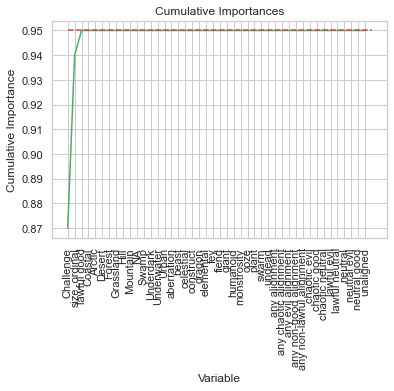

In [ ]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(feature_list, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(feature_list, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [4]:
import pydot
# Pull out one tree from the forest
Tree = model_D.estimators_[5]
# Export the image to a dot file
from sklearn import tree
plt.figure(figsize=(25,15))
tree.plot_tree(Tree,filled=True, 
              rounded=True, 
              fontsize=14);


NameError: name 'model_D' is not defined

## Baseline TensorFlow model Keras
evaluate the MLP model using repeated -fold cV with 10 folds and 3 repeats

In [40]:
# Turn data into numpy arrays
X = np.array(x_train)
Y = np.array(y_train)

24

In [41]:
#feature normlization will happen as part of keras preprocessing layer : Normalization
normalizer =  Normalization(axis=-1)
normalizer.adapt(X)

normalized_data = normalizer(X)
print("var: %.4f" % np.var(normalized_data))
print("mean: %.4f" % np.mean(normalized_data))

var: 0.9773
mean: -0.0000


In [52]:
# simple test model
x_train = np.array(x_train)
model = Sequential([
    normalizer,
    Dense(units=24)
])
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 44)               89        
 ion)                                                            
                                                                 
 dense_65 (Dense)            (None, 24)                1080      
                                                                 
Total params: 1,169
Trainable params: 1,080
Non-trainable params: 89
_________________________________________________________________


In [54]:
model.layers[1].kernel

<tf.Variable 'dense_65/kernel:0' shape=(44, 24) dtype=float32, numpy=
array([[-0.01796401, -0.15364617,  0.13675886, ...,  0.19373101,
         0.00286853,  0.24375588],
       [-0.15547314, -0.01526323,  0.25529855, ..., -0.02707192,
        -0.00542828,  0.19515175],
       [-0.10128808, -0.12273994,  0.17487082, ..., -0.27842653,
         0.00087696,  0.12451407],
       ...,
       [ 0.28340012,  0.1059593 ,  0.05410779, ..., -0.18465927,
        -0.01615742,  0.16496193],
       [-0.14496714, -0.15605117,  0.16302258, ...,  0.29406667,
        -0.25480047, -0.09689996],
       [ 0.24880338,  0.00278425, -0.17847973, ...,  0.1082027 ,
         0.03001529,  0.1041477 ]], dtype=float32)>

In [53]:
model.predict(x_test)

array([[-8.5653782e-01, -1.7881255e+00, -1.5499073e+00, ...,
        -4.1714951e-01,  6.2584996e-01,  6.9626951e-01],
       [ 1.9655063e+00, -6.0877198e-01, -7.3165798e-01, ...,
        -2.6221685e+00, -1.6848881e+00, -2.7493951e+00],
       [-6.0272557e-01, -5.2982378e-01,  1.4461610e+00, ...,
        -2.0487715e-01, -7.0137793e-01,  7.9091918e-01],
       ...,
       [-1.4929707e-01, -1.2255045e+00,  1.0540025e+00, ...,
        -5.5796444e-01, -2.5207801e+00,  6.6830873e-01],
       [ 1.0841999e+00,  5.2389503e-04, -1.7346369e+00, ...,
        -4.5074320e-01, -4.7922376e-01, -8.3392221e-01],
       [-1.1929382e+00,  4.6918786e-01,  2.5654769e-01, ...,
         1.2923336e-01,  7.1961629e-01,  1.0116501e+00]], dtype=float32)

In [59]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [60]:
%%time
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    verbose =0,
    validation_split = 0.2
)

CPU times: total: 4.34 s
Wall time: 3.86 s


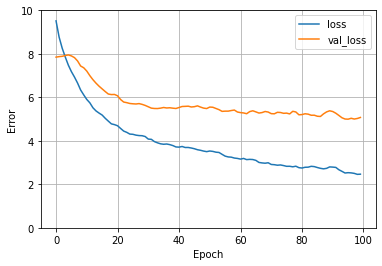

In [63]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [65]:
model.evaluate(x_test,y_test,verbose=0)

14397.0849609375

In [66]:
def build_and_compile_model(n_inputs, n_outputs,norm):
    model_tf = Sequential()
    norm,
    model_tf.add(Dense(20, input_dim = n_inputs, kernel_initializer = 'he_uniform', activation = 'relu'))
    model_tf.add(Dense(n_outputs))
    model_tf.compile(loss='mae', 
                     optimizer = tf.keras.optimizers.Adam(0.001))
    return model_tf

SyntaxError: positional argument follows keyword argument (3391978276.py, line 6)

In [ ]:
def evaluate_model(X,y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    #define evaluation procedure
    cv = RepeatedKFold(n_splits = 10, n_repeats=3, random_state=1)
    #enumerate folds
    for train_ix, test_ix in cv.split(X):
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        #define model
        model = get_model(n_inputs, n_outputs)
        #fit
        model.fit(X_train, y_train, verbose=0, epochs =100)
        #evaluate
        mae = model.evaluate(X_test, y_test, verbose=0)
        #store
        print('>%.3f' % mae)
        results.append(mae)
    return results

In [14]:
results = evaluate_model(np.array(X),np.array(Y))
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

>2.173
>2.482
>2.571
>2.175
>2.724
>2.542
>2.318
>2.219
>2.340
>2.325
>2.404
>1.761
>2.277
>2.399
>3.041
>2.335
>2.593
>1.923
>2.305
>2.405
>2.243
>2.162
>1.947
>2.059
>2.412
>2.375
>2.271
>2.419
>2.205
>3.118
MAE: 2.351 (0.278)


In [32]:
n_inputs, n_outputs = X.shape[1], Y.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
model.fit(np.array(X),np.array(Y),verbose=0,epochs=100)

In [33]:
row = [1,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,10]
newx = np.array(row)
yhat = model.predict(newx)
print ("Predicted: %s" %yhat[0])

ValueError: in user code:

    File "c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ingal\Documents\Data Science Work\DnD_Monsters\env\lib\site-packages\keras\engine\input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_30" (type Sequential).
    
    Input 0 of layer "dense_60" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=int32)
      • training=False
      • mask=None


In [24]:
X.columns

Index(['Coastal', 'Arctic', 'Desert', 'Forest', 'Grassland', 'Hill',
       'Mountain', 'NA', 'Swamp', 'Underdark', 'Underwater', 'Urban',
       'size_ordinal', 'aberration', 'beast', 'celestial', 'construct',
       'dragon', 'elemental', 'fey', 'fiend', 'giant', 'humanoid',
       'monstrosity', 'ooze', 'plant', 'swarm', 'undead', 'any alignment',
       'any chaotic alignment', 'any evil alignment', 'any non-good alignment',
       'any non-lawful alignment', 'chaotic evil', 'chaotic good',
       'chaotic neutral', 'lawful evil', 'lawful good', 'lawful neutral',
       'neutral', 'neutral evil', 'neutral good', 'unaligned', 'Challenge'],
      dtype='object')